In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.time import Time
from scipy.optimize import curve_fit
from scipy.special import erf

from lsst.summit.utils.efdUtils import makeEfdClient
from lsst.ts.xml.enums.MTM1M3 import HardpointTest

In [5]:
#CONFIGURATION

                # EFD client
efd_client = makeEfdClient("usdf_efd")
BASE_TOPIC = "lsst.sal.MTM1M3"
N_HP = 6

                # CONSTANTS
M_TO_UM = 1e6

COMP_LIMITS = (2981, 3959)
TENS_LIMITS = (-4420, -3456)
SPEC_STIFFNESS = 100  # N/um

DISPLACEMENT_CROP_RANGE = 500            # um (plot)
DISPLACEMENT_CROP_RANGE_FOR_FIT = 100    # um (fit region)
FIT_POINTS_AROUND_ZERO = 10              # ±10 points

STATUS_COLORS = {
    HardpointTest.MOVINGNEGATIVE:  "blue",
    HardpointTest.TESTINGPOSITIVE: "green",
    HardpointTest.TESTINGNEGATIVE: "red",
}

                # UTILS

# Ensure that index is in UTC
def ensure_utc_index(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return df
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    else:
        df.index = df.index.tz_convert("UTC")
    return df.sort_index()

# Save fig in directory
def save_fig(fig, outdir, fname, dpi=180):
    if outdir is None:
        return
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, fname)
    fig.savefig(path, dpi=dpi)
    print("Saved:", path)

# Segmentation
# Build change of states
def build_state_segments(status_series: pd.Series, t0: pd.Timestamp, t1: pd.Timestamp):
    """
    Returns [(start, end, state), ...] for state changes within [t0, t1].
    """
    if status_series is None or status_series.empty:
        return []

    s = status_series.dropna().astype(int)
    s = ensure_utc_index(s.to_frame("st"))["st"]
    s = s[(s.index >= t0) & (s.index <= t1)]
    if s.empty:
        return []

    # Ensure endpoints exist so we can slice edges
    if s.index[0] > t0:
        s.loc[t0] = s.iloc[0]
    if s.index[-1] < t1:
        s.loc[t1] = s.iloc[-1]
    s = s.sort_index()

    change = s.ne(s.shift())
    idx = np.where(change.to_numpy())[0]

    segs = []
    for i in range(len(idx)):
        a = s.index[idx[i]]
        b = s.index[idx[i + 1]] if (i + 1) < len(idx) else t1
        segs.append((a, b, int(s.iloc[idx[i]])))
    return segs

def pick_segment_for_state(segs, target_state: int):
    candidates = [(a, b) for (a, b, st) in segs if st == target_state and (b > a)]
    if not candidates:
        return None
    return max(candidates, key=lambda ab: (ab[1] - ab[0]))

def slice_actuator_by_segment(act_df: pd.DataFrame, seg, pad_s: float = 1.0):
    if seg is None or act_df is None or act_df.empty:
        return pd.DataFrame()
    a, b = seg
    a = a - pd.Timedelta(seconds=pad_s)
    b = b + pd.Timedelta(seconds=pad_s)
    return act_df[(act_df.index >= a) & (act_df.index <= b)].copy()

# Centering + stiffness
def center_df_force_disp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_index().copy()
    i0 = df["force"].abs().idxmin()         #Force ~0 
    x0 = float(df.loc[i0, "displacement"])  # We are looking for the point 0,0 
    y0 = float(df.loc[i0, "force"])         
    df["displacement"] -= x0
    df["force"] -= y0
    return df                               #Now it is in origin 

def slope_through_origin(x: np.ndarray, y: np.ndarray) -> float:
    denom = float(np.dot(x, x))
    if denom == 0 or not np.isfinite(denom):
        return np.nan
    return float(np.dot(x, y) / denom)

def fit_stiffness_centered(df_state: pd.DataFrame):
    """
    Center by min|F| point -> (0,0), then pick ±FIT_POINTS_AROUND_ZERO around x≈0 and fit y=kx through origin.
    Returns: k, df_plot (centered and cropped for plotting)
    """
    if df_state is None or df_state.empty or len(df_state) < 20:
        return np.nan, pd.DataFrame()

    dfc = center_df_force_disp(df_state)

    # crop for plot
    df_plot = dfc[dfc["displacement"].abs() <= DISPLACEMENT_CROP_RANGE].copy()
    if df_plot.empty or len(df_plot) < 10:
        return np.nan, df_plot

    # crop for fit region
    df_center = df_plot[df_plot["displacement"].abs() <= DISPLACEMENT_CROP_RANGE_FOR_FIT].copy()
    if df_center.empty or len(df_center) < 5:
        df_center = df_plot

    x = df_center["displacement"].to_numpy(float)
    j0 = int(np.argmin(np.abs(x)))

    lo = max(0, j0 - FIT_POINTS_AROUND_ZERO)
    hi = min(len(df_center), j0 + FIT_POINTS_AROUND_ZERO + 1)
    df_fit = df_center.iloc[lo:hi]

    if len(df_fit) < 5:
        return np.nan, df_plot

    xf = df_fit["displacement"].to_numpy(float)
    yf = df_fit["force"].to_numpy(float)

    k = slope_through_origin(xf, yf)
    return k, df_plot

            # EFD QUERIES (ASYNC)

async def fetch_status(t0: pd.Timestamp, t1: pd.Timestamp) -> pd.DataFrame:
    df = await efd_client.select_time_series(
        topic_name=f"{BASE_TOPIC}.logevent_hardpointTestStatus",
        fields=[f"testState{i}" for i in range(N_HP)],
        start=Time(t0.to_pydatetime(), scale="utc"),
        end=Time(t1.to_pydatetime(), scale="utc"),
    )
    if df is None or df.empty:
        return pd.DataFrame()
    return ensure_utc_index(df)

async def fetch_actuator_force_disp(t0: pd.Timestamp, t1: pd.Timestamp, hp_idx: int) -> pd.DataFrame:
    df = await efd_client.select_time_series(
        topic_name=f"{BASE_TOPIC}.hardpointActuatorData",
        fields=[f"measuredForce{hp_idx}", f"displacement{hp_idx}"],
        start=Time(t0.to_pydatetime(), scale="utc"),
        end=Time(t1.to_pydatetime(), scale="utc"),
    )
    if df is None or df.empty:
        return pd.DataFrame()

    df = ensure_utc_index(df).rename(columns={
        f"measuredForce{hp_idx}": "force",
        f"displacement{hp_idx}": "disp_m",
    })
    df["displacement"] = df["disp_m"] * M_TO_UM
    return df[["force", "displacement"]].dropna().sort_index()

                    # RESIDUAL (ERF - Model S)
def erf_model(x, a, x0, w, b, c):
    return a * erf((x - x0) / w) + b + c * x

def fit_erf_curve(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    ymin, ymax = np.nanmin(y), np.nanmax(y)
    a0 = 0.5 * (ymax - ymin)
    b0 = 0.5 * (ymax + ymin)
    idx0 = int(np.argmin(np.abs(y - b0)))
    x0_0 = float(x[idx0])
    w0 = 80.0
    c0 = 0.0

    p0 = [a0, x0_0, w0, b0, c0]
    lower = [-1e5, -1e4,  1.0, -1e5, -50.0]
    upper = [ 1e5,  1e4, 2e3,  1e5,  50.0]

    popt, _ = curve_fit(
        erf_model, x, y,
        p0=p0, bounds=(lower, upper),
        maxfev=20000
    )
    return popt

def plot_error_residual(ax_fd, ax_res, df_pos, df_neg, title, max_markers=30):
    def plot_one(df, label, color):
        df = df.dropna().sort_index()
        x = df["displacement"].to_numpy(float)
        y = df["force"].to_numpy(float)

        if len(df) < 20:
            ax_fd.plot(x, y, "-", color=color, linewidth=2, label=label)
            return

        step = max(1, len(df) // max_markers)

        popt = fit_erf_curve(x, y)
        y_fit = erf_model(x, *popt)
        resid = y - y_fit

        ax_fd.plot(
            x, y, "-", color=color, alpha=0.75, linewidth=2,
            marker="o", markersize=3, markevery=step, markeredgewidth=0,
            label=label
        )
        ax_fd.plot(x, y_fit, "--", color=color, linewidth=2.5, label=f"{label} fit")
        ax_res.plot(x, resid, "-", color=color, linewidth=2, label=f"Residual - {label}")

    # Cosmetics (left)
    ax_fd.axhspan(COMP_LIMITS[0], COMP_LIMITS[1], color="lightgrey", alpha=0.30)
    ax_fd.axhspan(TENS_LIMITS[0], TENS_LIMITS[1], color="yellow", alpha=0.15)
    ax_fd.axvline(0, color="black", linewidth=1, alpha=0.6)
    ax_fd.axhline(0, color="black", linewidth=1, alpha=0.6)
    ax_fd.text(-DISPLACEMENT_CROP_RANGE * 0.95, (COMP_LIMITS[0] + COMP_LIMITS[1]) / 2,
               "Compression", ha="left", va="center", fontsize=9, fontweight="bold")
    ax_fd.text(-DISPLACEMENT_CROP_RANGE * 0.95, (TENS_LIMITS[0] + TENS_LIMITS[1]) / 2,
               "Tension", ha="left", va="center", fontsize=9, fontweight="bold")

    # Cosmetics (right)
    ax_res.axvline(0, color="black", linewidth=1, alpha=0.6)
    ax_res.axhline(0, color="black", linewidth=1, alpha=0.6)

    plot_one(df_pos, "Testing Positive", "tab:green")
    plot_one(df_neg, "Testing Negative", "tab:red")

    ax_fd.set_title(title, fontsize=9)
    ax_fd.set_xlabel("Displacement (µm)", fontsize=9)
    ax_fd.set_ylabel("Force (N)", fontsize=9)
    ax_fd.grid(True, alpha=0.25, linestyle="--")
    ax_fd.legend(loc="upper left", fontsize=8, frameon=True)

    ax_res.set_xlabel("Displacement (µm)", fontsize=9)
    ax_res.set_ylabel("Residual (data - fit)", fontsize=9)
    ax_res.grid(True, alpha=0.25, linestyle="--")
    ax_res.legend(loc="lower right", fontsize=8, frameon=True)

In [6]:
# RUN

#Define hp's windows, segment in MN/TP/TN
async def run_day_plots(
    day_str: str,
    hp_time_windows: dict,
    outdir: str | None = None,
    el_str="90",
    az_str="-29.69",
    salindex="100061",
):
    results = []

    for hp in range(1, N_HP + 1):
        if hp not in hp_time_windows:
            continue

        start_hms, end_hms = hp_time_windows[hp]
        t0 = pd.Timestamp(f"{day_str} {start_hms}", tz="UTC")
        t1 = pd.Timestamp(f"{day_str} {end_hms}", tz="UTC")

        hp_idx = hp - 1

        # Fetch data (ASYNC)
        #Data frame with UTC & states hp{i}
        status_df = await fetch_status(t0, t1)
        act_df = await fetch_actuator_force_disp(t0, t1, hp_idx)

        if status_df.empty or act_df.empty:
            print(f"HP{hp}: missing data status={len(status_df)} act={len(act_df)}")
            continue

        # Segment by REAL state transitions
        state_col = f"testState{hp_idx}"
        segs = build_state_segments(status_df[state_col], t0, t1)

        seg_mn = pick_segment_for_state(segs, int(HardpointTest.MOVINGNEGATIVE))
        seg_tp = pick_segment_for_state(segs, int(HardpointTest.TESTINGPOSITIVE))
        seg_tn = pick_segment_for_state(segs, int(HardpointTest.TESTINGNEGATIVE))

        moving_negative_data = slice_actuator_by_segment(act_df, seg_mn, pad_s=1.0)
        test_positive_data   = slice_actuator_by_segment(act_df, seg_tp, pad_s=1.0)
        test_negative_data   = slice_actuator_by_segment(act_df, seg_tn, pad_s=1.0)

        if moving_negative_data.empty or test_positive_data.empty or test_negative_data.empty:
            print(f"HP{hp}: incomplete states -> mn={len(moving_negative_data)} pos={len(test_positive_data)} neg={len(test_negative_data)}")
            continue

        # Debug min|F|
        print(f"HP{hp} MN  points={len(moving_negative_data)} min|F|={moving_negative_data['force'].abs().min():.1f}")
        print(f"HP{hp} POS points={len(test_positive_data)}   min|F|={test_positive_data['force'].abs().min():.1f}")
        print(f"HP{hp} NEG points={len(test_negative_data)}   min|F|={test_negative_data['force'].abs().min():.1f}")

        
        # PLOT: STIFFNESS
        
        fig, ax = plt.subplots(figsize=(10, 8))

        ax.axhspan(COMP_LIMITS[0], COMP_LIMITS[1], color="lightgrey", alpha=0.30)
        ax.axhspan(TENS_LIMITS[0], TENS_LIMITS[1], color="yellow", alpha=0.15)

        ax.text(-DISPLACEMENT_CROP_RANGE * 0.95, (COMP_LIMITS[0] + COMP_LIMITS[1]) / 2,
                "Compression", ha="left", va="center", fontsize=9, fontweight="bold")
        ax.text(-DISPLACEMENT_CROP_RANGE * 0.95, (TENS_LIMITS[0] + TENS_LIMITS[1]) / 2,
                "Tension", ha="left", va="center", fontsize=9, fontweight="bold")

        stiffs = {}

        for df_state, label, st_enum in [
            (moving_negative_data, "Moving Negative", HardpointTest.MOVINGNEGATIVE),
            (test_positive_data,   "Testing Positive", HardpointTest.TESTINGPOSITIVE),
            (test_negative_data,   "Testing Negative", HardpointTest.TESTINGNEGATIVE),
        ]:
            k, df_plot = fit_stiffness_centered(df_state)
            stiffs[label] = k

            c = STATUS_COLORS[st_enum]
            MAX_MARKERS = 120
            step = max(1, len(df_plot) // MAX_MARKERS)

            ax.plot(
                df_plot["displacement"], df_plot["force"],
                "-", color=c, alpha=1.0, linewidth=2,
                marker="o", markersize=4, markevery=step,
                markeredgewidth=0,
                label=label
            )

            if np.isfinite(k):
                fit_x = df_plot["displacement"].to_numpy(float)
                fit_y = k * fit_x
                ax.plot(fit_x, fit_y, "-", color=c, linewidth=2, label="_nolegend_")

        x_spec = np.linspace(-DISPLACEMENT_CROP_RANGE, DISPLACEMENT_CROP_RANGE, 200)
        y_spec = x_spec * SPEC_STIFFNESS
        ax.plot(x_spec, y_spec, ":", color="black", linewidth=2, label=f"Spec ({SPEC_STIFFNESS} N/µm)")

        ax.axvline(0, color="black", linewidth=1, alpha=0.5)
        ax.axhline(0, color="black", linewidth=1, alpha=0.5)

        ax.set_title(
            f"Individual Hardpoint Breakaway Test at El:{el_str} deg, Az:{az_str} deg\n"
            f"HP{hp} SAL Index {salindex} Stiffness | {day_str} {t0.strftime('%H:%M:%S')}-{t1.strftime('%H:%M:%S')} UTC",
            fontsize=11
        )
        ax.set_xlabel("Displacement [µm]", fontsize=11)
        ax.set_ylabel("Force [N]", fontsize=11)
        ax.grid(True, alpha=0.25, linestyle="--")
        ax.tick_params(axis="both", labelsize=10)

        leg = ax.legend(loc="upper left", fontsize=9, frameon=True)
        leg.get_frame().set_alpha(0.9)

        def fmt(v):
            try:
                if v is None:
                    return "NaN"
                v = float(v)
                return "NaN" if not np.isfinite(v) else f"{v:.2f}"
            except Exception:
                return "NaN"

        stiff_text = (
            "Stiffness N/µm\n"
            f"Moving Negative: {fmt(stiffs.get('Moving Negative'))}\n"
            f"Testing Positive: {fmt(stiffs.get('Testing Positive'))}\n"
            f"Testing Negative: {fmt(stiffs.get('Testing Negative'))}"
        )

        ax.text(
            0.98, 0.02, stiff_text,
            transform=ax.transAxes, ha="right", va="bottom",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9, edgecolor="black")
        )

        ax.set_xlim(-DISPLACEMENT_CROP_RANGE - 50, DISPLACEMENT_CROP_RANGE + 50)
        ax.set_ylim(-6000, 6000)

        plt.tight_layout()
        plt.show()

        save_fig(fig, outdir, f"stiffness_HP{hp}_{day_str}_{start_hms.replace(':','')}_{end_hms.replace(':','')}.png")
        plt.close(fig)

        
        # PLOT: RESIDUAL 
     
        tp_centered = center_df_force_disp(test_positive_data[["force", "displacement"]])
        tn_centered = center_df_force_disp(test_negative_data[["force", "displacement"]])

        fig2, (ax_fd, ax_res) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"width_ratios": [1, 1]})

        title2 = (
            f"Individual Hardpoint Breakaway Test at El:{el_str} deg, Az:{az_str} deg\n"
            f"HP{hp} SAL Index {salindex} | {day_str} {t0.strftime('%H:%M:%S')}-{t1.strftime('%H:%M:%S')} UTC"
        )

        plot_error_residual(ax_fd, ax_res, tp_centered, tn_centered, title=title2, max_markers=90)

        ax_fd.set_xlim(-DISPLACEMENT_CROP_RANGE - 50, DISPLACEMENT_CROP_RANGE + 50)
        ax_fd.set_ylim(-6000, 6000)
        ax_res.set_xlim(-DISPLACEMENT_CROP_RANGE - 50, DISPLACEMENT_CROP_RANGE + 50)
        ax_res.set_ylim(-1000, 1000)

        plt.tight_layout()
        plt.show()

        save_fig(fig2, outdir, f"residual_HP{hp}_{day_str}_{start_hms.replace(':','')}_{end_hms.replace(':','')}.png")
        plt.close(fig2)

        
        # RESULTS ROWS
        
        results.append({
            "Date": day_str,
            "Hardpoint": f"HP{hp}",
            "Start_UTC": t0.strftime("%Y-%m-%d %H:%M:%S"),
            "End_UTC": t1.strftime("%Y-%m-%d %H:%M:%S"),
            "Stiffness_MovingNegative": stiffs.get("Moving Negative", np.nan),
            "Stiffness_TestingPositive": stiffs.get("Testing Positive", np.nan),
            "Stiffness_TestingNegative": stiffs.get("Testing Negative", np.nan),
        })

    return pd.DataFrame(results) if results else pd.DataFrame()

HP1 MN  points=5100 min|F|=5.4
HP1 POS points=11999   min|F|=10.4
HP1 NEG points=11999   min|F|=16.2


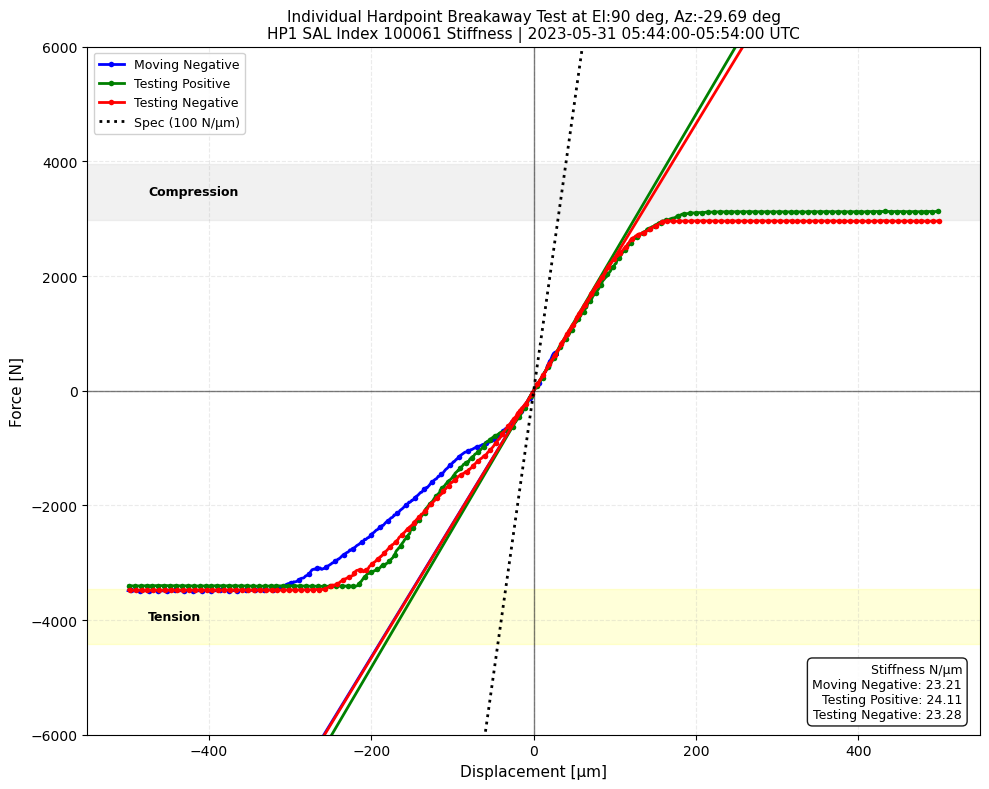

Saved: plots/2023-05-31/stiffness_HP1_2023-05-31_054400_055400.png


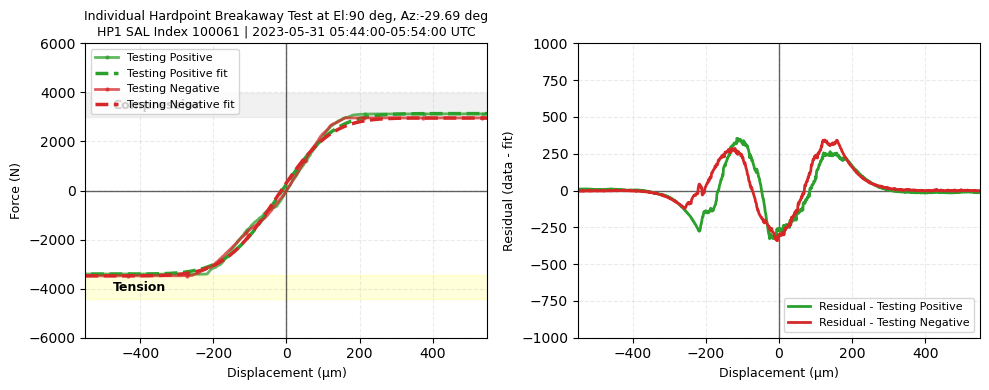

Saved: plots/2023-05-31/residual_HP1_2023-05-31_054400_055400.png
HP2 MN  points=5045 min|F|=11.4
HP2 POS points=13203   min|F|=15.3
HP2 NEG points=13202   min|F|=6.2


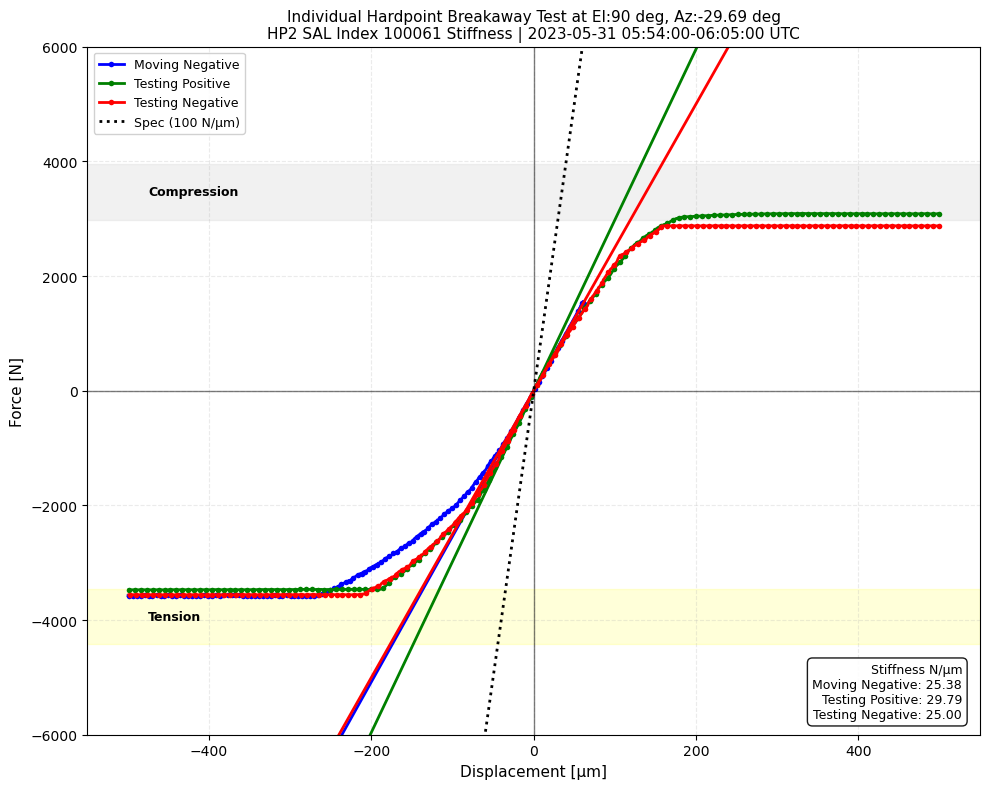

Saved: plots/2023-05-31/stiffness_HP2_2023-05-31_055400_060500.png


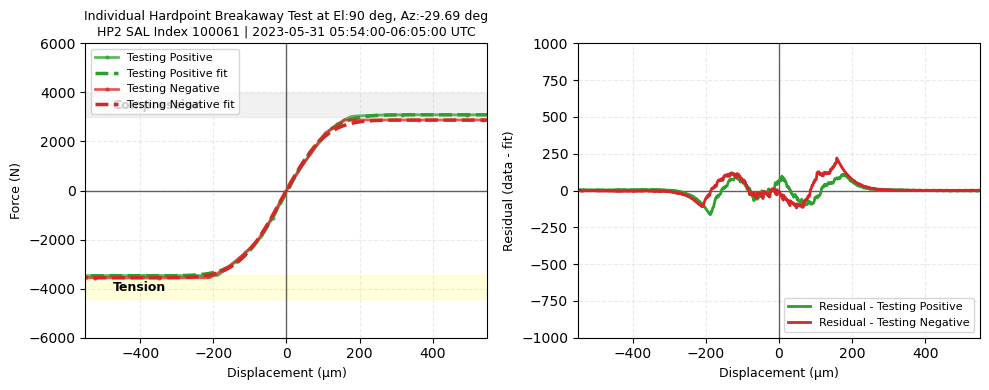

Saved: plots/2023-05-31/residual_HP2_2023-05-31_055400_060500.png
HP3 MN  points=6590 min|F|=30.2
HP3 POS points=11734   min|F|=15.8
HP3 NEG points=10895   min|F|=19.6


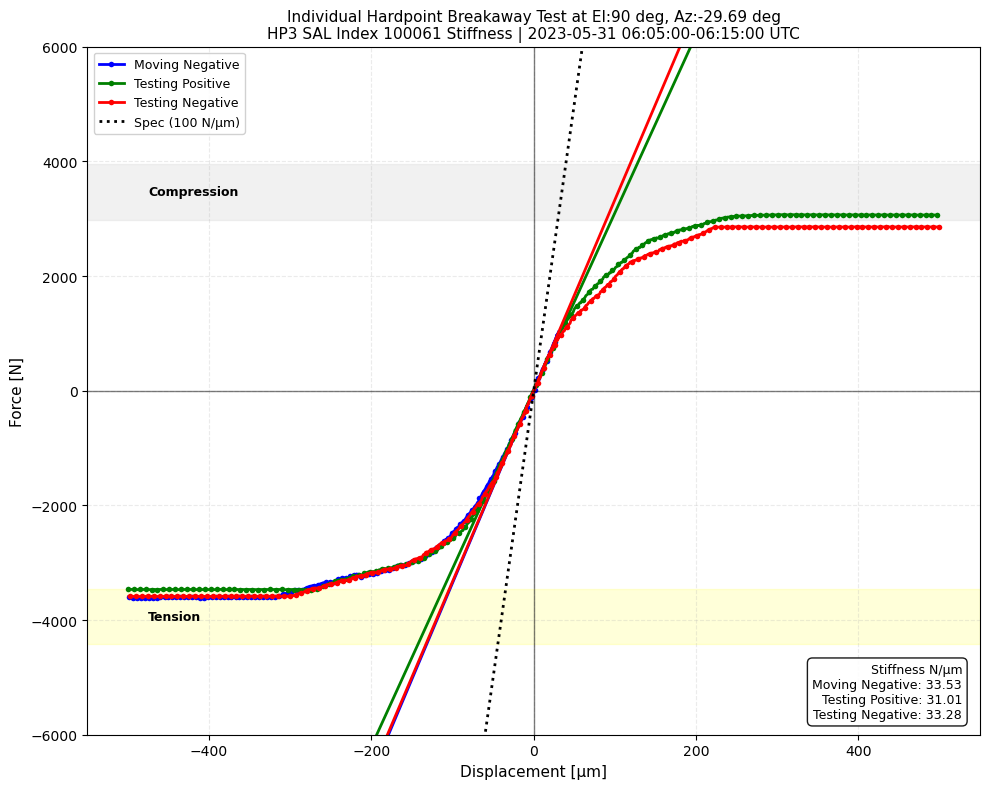

Saved: plots/2023-05-31/stiffness_HP3_2023-05-31_060500_061500.png


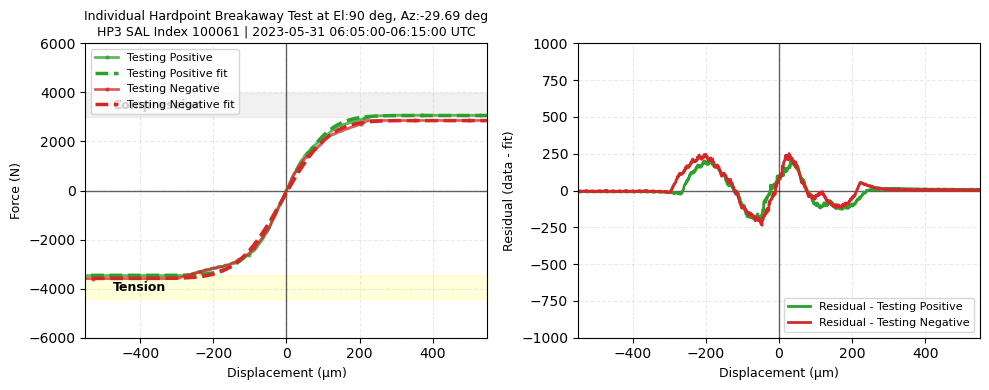

Saved: plots/2023-05-31/residual_HP3_2023-05-31_060500_061500.png
HP4 MN  points=6654 min|F|=0.8
HP4 POS points=11638   min|F|=17.8
HP4 NEG points=11636   min|F|=12.9


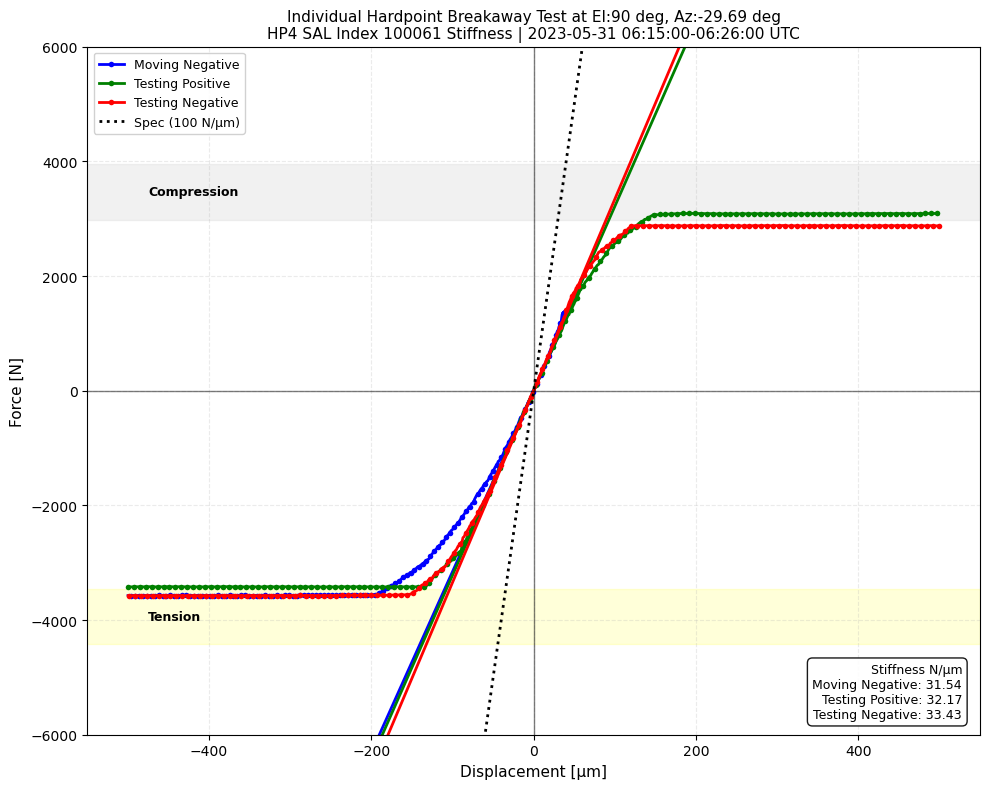

Saved: plots/2023-05-31/stiffness_HP4_2023-05-31_061500_062600.png


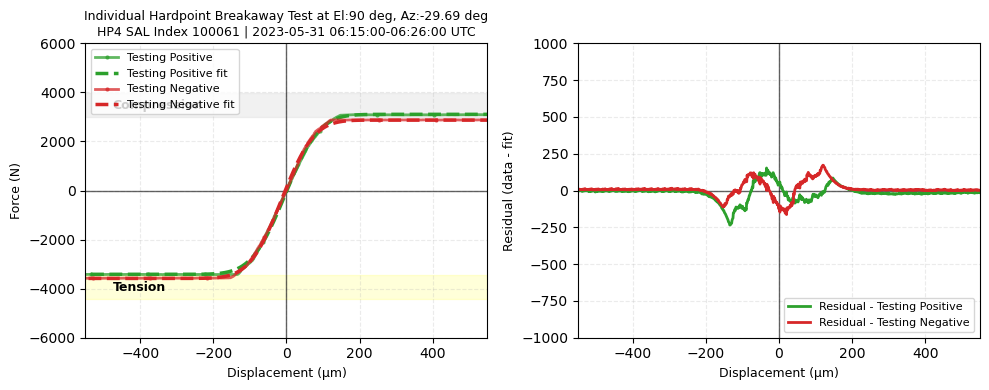

Saved: plots/2023-05-31/residual_HP4_2023-05-31_061500_062600.png
HP5 MN  points=4054 min|F|=1.6
HP5 POS points=13590   min|F|=21.1
HP5 NEG points=13592   min|F|=3.1


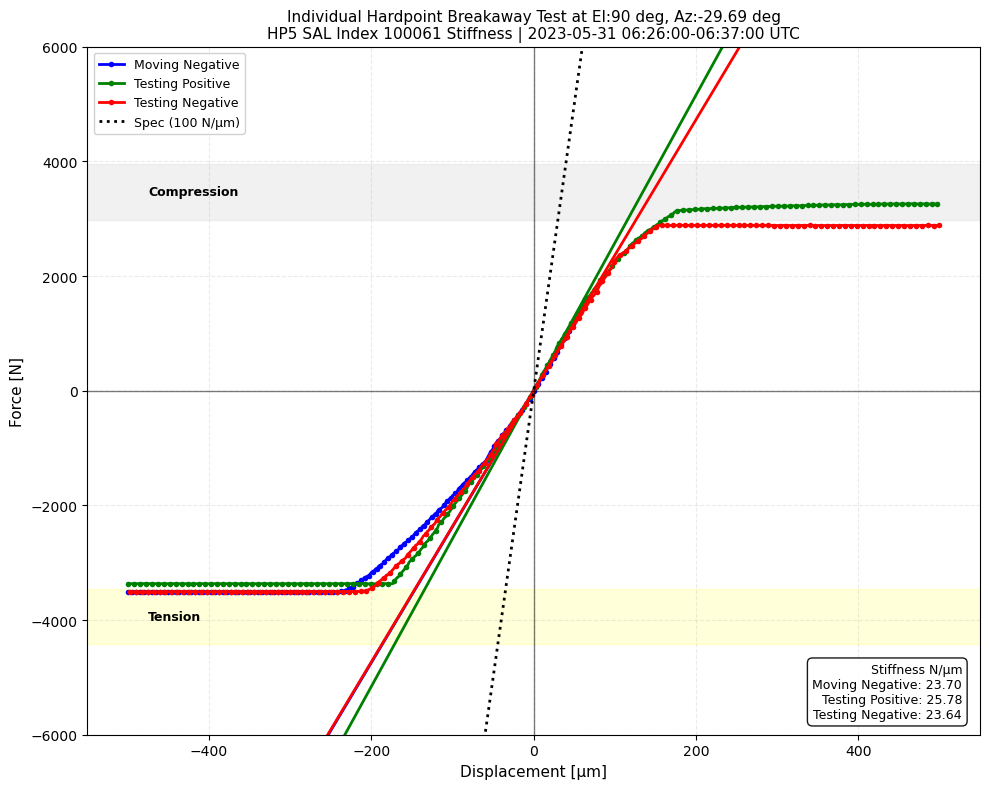

Saved: plots/2023-05-31/stiffness_HP5_2023-05-31_062600_063700.png


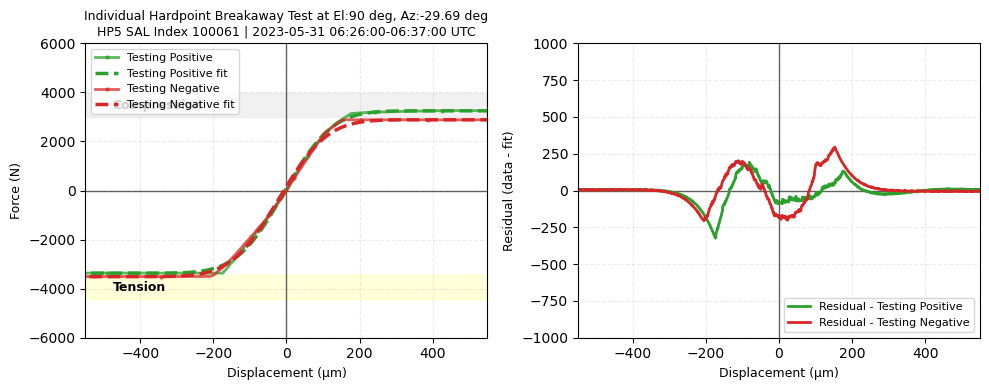

Saved: plots/2023-05-31/residual_HP5_2023-05-31_062600_063700.png
HP6 MN  points=6113 min|F|=1.6
HP6 POS points=11978   min|F|=9.7
HP6 NEG points=11977   min|F|=25.3


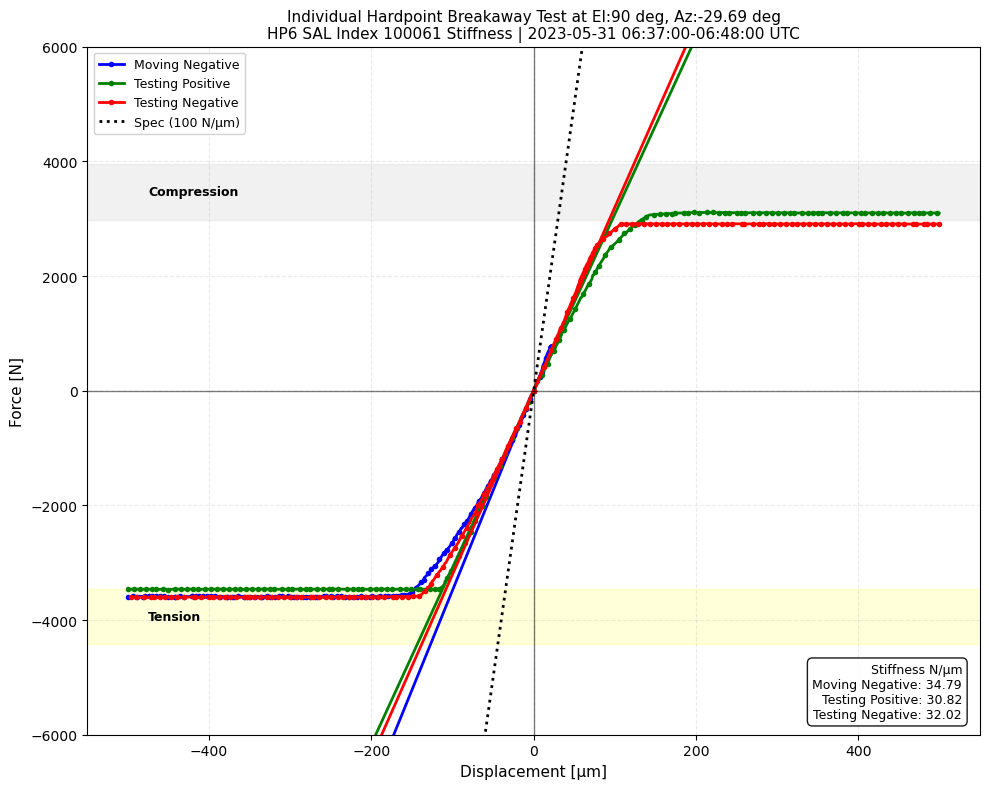

Saved: plots/2023-05-31/stiffness_HP6_2023-05-31_063700_064800.png


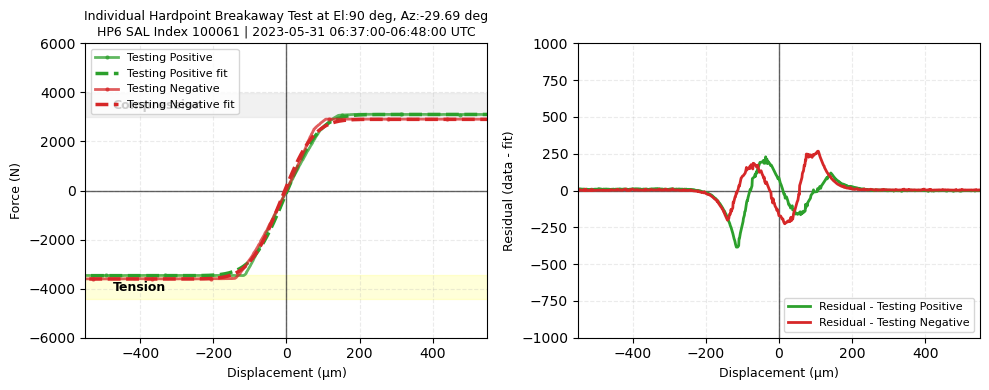

Saved: plots/2023-05-31/residual_HP6_2023-05-31_063700_064800.png


,Date,Hardpoint,Start_UTC,End_UTC,Stiffness_MovingNegative,Stiffness_TestingPositive,Stiffness_TestingNegative
0,2023-05-31,HP1,2023-05-31 05:44:00,2023-05-31 05:54:00,23.206377,24.110155,23.278651
1,2023-05-31,HP2,2023-05-31 05:54:00,2023-05-31 06:05:00,25.384438,29.786387,25.000044
2,2023-05-31,HP3,2023-05-31 06:05:00,2023-05-31 06:15:00,33.527585,31.008367,33.283055
3,2023-05-31,HP4,2023-05-31 06:15:00,2023-05-31 06:26:00,31.538660,32.167865,33.428900
4,2023-05-31,HP5,2023-05-31 06:26:00,2023-05-31 06:37:00,23.704553,25.782907,23.640251
5,2023-05-31,HP6,2023-05-31 06:37:00,2023-05-31 06:48:00,34.787872,30.815615,32.022410


In [7]:
df_results = await run_day_plots(
    day_str="2023-05-31",
    hp_time_windows={
        1: ("05:44:00", "05:54:00"),
        2: ("05:54:00", "06:05:00"),
        3: ("06:05:00", "06:15:00"),
        4: ("06:15:00", "06:26:00"),
        5: ("06:26:00", "06:37:00"),
        6: ("06:37:00", "06:48:00"),
    },
    outdir=f"plots/2023-05-31",
    el_str="90",
    az_str="-29.69",
    salindex="100061",
)

display(df_results)